
为了让我们的AI更加全能，我们可以结合之前构建的所有工具和智能体，制作类似GPT-4首页的all tools功能，让AI综合使用多个工具，比如：
- 联网搜索（bing搜索）：get_bing_searched_results(keyword='智能体', max_results=5)
- code interpreter：运行代码 run_code_v2(code)
- PDF阅读: pdf_texts = extract_clean_text_from_pdf(pdf_path, method='pdfminer')

此外，我们还可以弥补大模型官网的缺陷，提供更多工具，让AI能精准搜索我们想要的数量的论文，或者爬取特定网页的内容
- arxiv 
- 知网搜索
- 股吧情绪分析
...

想加多少加多少~

这个智能体可以最终实现的功能是：
根据用户的问题，自动选择最佳工具获取信息，解答问题。
- 如果需要做数据分析，则调用code interpreter运行代码；
- 如果需要搜索，则调用bing搜索；
- 如果需要阅读文献，则调用PDF阅读器
...以此类推


我们把这个智能体系统分为两个部分，一个是智能体本身，另外一个是工具选择器。
任何问题都会先经过工具选择器，让其选择最合适的工具，为智能体提供需要的信息。

未来更加进阶的智能体，会基于这个拥有多个工具的基础智能体进行开发，拥有以下功能：
- 记住我们的喜好（参考mem0）
- 自主上网学习最新知识，保存到知识库，随时调取（参考GraphRAG构建知识图谱）
- 自我进化，每次都能输出最高质量的回答
- 完成论文中的实证部分...
- 头脑风暴获取极具创意的想法
- 自主学习并构建全新的工具
- 多工具同时调用，汇总信息，给出答案
- 需要增加一个复杂问题解决流程，让智能体多次调用工具，综合多个工具的结果，最后给出答案。（使用"[END]"标记作为结束）
- 增加一个网页界面
- 随着聊天变长，随机遗忘不重要的信息。（可设计一个重要程度判断模型）
- 文件上传分析（读取文件、分析文件）

不断给自己画饼，hhh


In [2]:
from growing_agent_tools.llm_api import * 
from growing_agent_tools.json_tool import *
from growing_agent_tools.code_interpreter import * 
from growing_agent_tools.search_bing import *
from growing_agent_tools.search_arxiv import *
from growing_agent_tools.search_cnki import *
from growing_agent_tools.text2jupyter import text_to_jupyter
from growing_agent_tools.pdf_reader import * 
from functools import wraps

class AllToolsAgent:
    
    def __init__(self, agent_name="AllTools"
                 , model="glm-4-0520"
                 , temperature=0.9):
        self.name = agent_name
        self.model = model
        self.temperature = temperature

        # 获取files文件夹下的所有文件
        files = os.listdir("files")
        self.files = [f for f in files if f.endswith(".pdf")]
                
        # 工具选择系统
        self.tool_system_prompt = self.get_prompt("prompts/tool_system_prompt.txt")
        self.tool_system_prompt = self.tool_system_prompt.format(files=self.files)
        self.tool_conversations = [{"role": "system", "content": self.tool_system_prompt}]
        
        # 回答系统
        self.agent_system_prompt = '''你必须尽可能详细地回答我的问题。'''
        self.agent_conversations = [{"role": "system", "content": self.agent_system_prompt}]
        
        # tool list
        self.tool_list = [
            "chat",
            "get_bing_searched_results",
            "extract_clean_text_from_pdf",
            "get_arxiv_papers",
            "run_code_v2",
            "get_cnki_searched_results"
        ]

        
    # 提示词读取
    def get_prompt(self, path):
        with open(path, 'r', encoding="utf-8") as file:
            prompt = file.read()
        return prompt
    
    # 简单模型单次回答
    def get_simple_answer(self, question, model, temperature=0.9):
        ans = ""
        for char in get_llm_answer(question, model, temperature):
            ans += char
            print(char, end='', flush=True)
        return ans
    
    # 普通回答：添加至聊天记录
    def get_answer(self, question):
        self.tool_conversations.append({"role": "user", "content": question})
        ans = ""
        for char in get_llm_answer_converse(self.tool_conversations, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        self.tool_conversations.append({"role": "assistant", "content": ans})
        return ans
    
    # 依据聊天记录回答
    def get_answer_converse(self, conversation):
        ans = ""
        for char in get_llm_answer_converse(conversation, self.model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        conversation.append({"role": "assistant", "content": ans})
        return conversation
    
    def select_tool(self, question, tool_model="deepseek-chat"):
        # 选择工具
        self.tool_conversations.append({"role": "user", "content": question})
        ans = ""
        for char in get_llm_answer_converse(self.tool_conversations, tool_model, self.temperature):
            ans += char
            print(char, end='', flush=True)
        self.tool_conversations.append({"role": "assistant", "content": ans})
        # 将空格替换
        tool = get_json(ans)["tool"]
        if tool.startswith("get_bing_searched_results"):
            tool = tool.replace(" ", "")
        print(f"\n\ntool: {tool}")
        return tool
    
    
    # 工作流
    def work_flow(self, question, tool_model="deepseek-chat"):
        # 选择工具
        tool = self.select_tool(question, tool_model)
        if tool == "chat":
            self.agent_conversations.append({"role": "user", "content": question})
            self.agent_conversations = self.get_answer_converse(self.agent_conversations)
            
        # 必应搜索
        elif tool.startswith("get_bing_searched_results"):
            result, console_output = run_code_v2(tool, globals=globals())
            print(f"搜索结果如下：{result[:1000]}")
            self.agent_conversations.append({"role": "user", "content": f'你帮我搜索到的结果：{result} | {console_output}'})
            self.agent_conversations = self.get_answer_converse(self.agent_conversations)
            
        # arXiv搜索
        elif tool.startswith("get_arxiv_papers"):
            result, console_output = run_code_v2(tool, globals=globals())
            self.agent_conversations.append({"role": "user", "content": f'arXiv的内容：{result} | {console_output}'})
            self.agent_conversations = self.get_answer_converse(self.agent_conversations)
                        
        # PDF阅读
        elif tool.startswith("extract_clean_text_from_pdf"):
            result, console_output = run_code_v2(tool, globals=globals())
            pdf_texts = result.replace("\n\n", " ")
            self.agent_conversations.append({"role": "user", "content": f'PDF的内容：{pdf_texts}'})
            self.agent_conversations = self.get_answer_converse(self.agent_conversations)
        
        # code interpreter
        elif tool.startswith("run_code_v2"):
            # 写代码
            self.agent_conversations.append({"role": "user", "content": question})
            ans = ""
            for char in auto_code_running_modify(question, self.model):
                print(char, end='', flush=True)
                ans += char
            self.agent_conversations.append({"role": "assistant", "content": ans})
            # 解释代码
            self.agent_conversations.append({"role": "user", "content": "解读代码运行结果"})
            self.agent_conversations = self.get_answer_converse(self.agent_conversations) 

        
# import os 
# os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
# os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


2024-07-23 02:00:32,916 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
    "tool": "run_code_v2()"
}
```

tool: run_code_v2()


2024-07-23 02:00:35,022 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


# 分析问题
为了构建两只股票的虚拟数据并画出走势图，我们需要考虑以下问题：

1. 生成股票数据的模型：通常股票价格会呈现随机游走的特点，因此我们可以使用几何布朗运动模型或者简单的随机漫步模型来生成股票价格。
2. 需要使用的库：我们将需要使用`numpy`来生成随机数据，使用`matplotlib`来绘制走势图。
3. 数据的起始点和时间框架：我们需要定义股票价格的起始点以及生成数据的时间框架（例如，一天一个数据点，持续一年）。
4. 股票价格的变化范围和波动性：为了使数据更接近真实走势，我们需要定义股票价格的波动性。

# 撰写代码的步骤
1. 导入必要的库。
2. 定义生成股票数据的函数。
3. 设置起始价格、时间框架、波动性等参数。
4. 生成两只股票的虚拟数据。
5. 绘制两只股票的走势图。

# 代码实现

```python
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字符显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义生成股票数据的函数
def generate_stock_data(start_price, days, volatility):
    # 初始化价格数组
    prices = np.zeros(days)
    prices[0] = start_price
    
    # 生成随机漫步数据
    for t in range(1, days):
        shock = np.random.normal(loc=0.0002, scale=volatility) # 每天的收益率服从正态分布
        prices[t] = prices[t-1] * (1 + shock)
    
    return prices

# 设置参数
start_price_1 = 100  # 股票1的起始价格
start_price_2 = 100  # 股票2的起始价格
days = 252           # 一年的交易日
volatility_1 = 0.005 # 股票1的波动性
vol

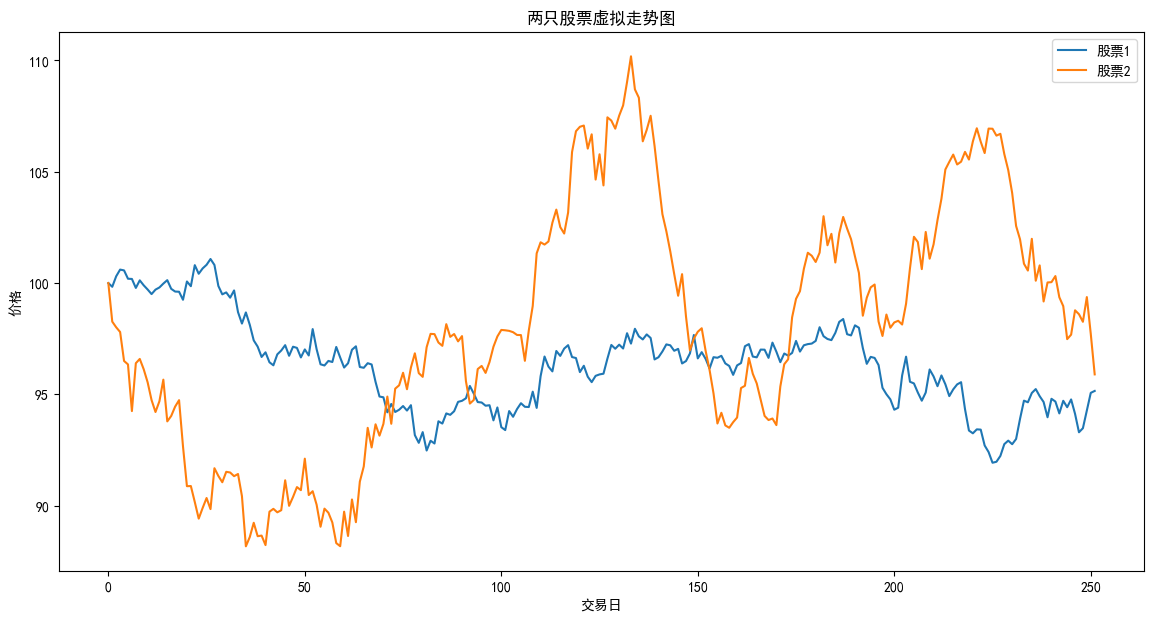

代码执行成功
运行结果：
代码执行成功
Successfully saved notebook to code_agent_written_codes/07-23-02-00-stocks.ipynb
代码执行成功,请查看代码文件夹


2024-07-23 02:00:55,282 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


代码执行后，将生成以下结果：

1. **随机股票价格数据**：利用`generate_stock_data`函数，我们为两只股票生成了模拟价格数据。该数据是基于随机漫步模型，每一天的价格都是基于前一天的价格和随机生成的收益（或亏损）。

2. **绘图**：使用了`matplotlib.pyplot`库的功能来绘制股票价格随时间的变化图。

以下是对结果的解读：

- **走势图**：在绘制的走势图中，横轴代表时间（以交易日为单位），纵轴代表股票价格。因为我们没有提供具体的时间标签，所以横轴只显示交易日的编号。

- **股票1和股票2**：两条曲线分别代表两个不同的股票的价格走势。由于我们设置了不同的波动性参数（`volatility_1` 和 `volatility_2`），两只股票的价格波动程度会有所不同。

- **波动性**：波动性较高的股票（股票2）在走势图上会显示出更剧烈的价格波动，表现为曲线的锯齿状更明显。波动性较低的股票（股票1）的价格变化则相对平缓。

- **起始价格**：两只股票的起始价格都设为100，这意味着它们从同一起点开始。

- **整体趋势**：由于我们是随机生成每天的收益，这些股票的长期走势是随机的，没有特定的上升或下降趋势。

- **图例**：图例标明了每条曲线代表的股票。

通过观察走势图，我们可以了解股票价格随时间的波动情况，分析它们的风险特征。在实际应用中，投资者会根据这些走势图以及相应的统计指标来做出投资决策。

请注意，虽然我们尽力使模拟数据接近真实股票走势，但实际股市受到的影响更为复杂，包括宏观经济、公司业绩、市场情绪等多种因素，因此模拟数据并不能完全反映真实的市场行为。

In [3]:
# code interpreter
question = "给我用Python构建两只股票的虚拟数据，非常接近真实走势，画出走势图。"

model = "glm-4-0520"
agent = AllToolsAgent(model=model)
# tool = agent.select_tool(question, tool_model="deepseek-chat")
agent.work_flow(question)

In [3]:
agent.agent_conversations

[{'role': 'system', 'content': '你必须尽可能详细地回答我的问题。'},
 {'role': 'user', 'content': '给我用Python构建两只股票的虚拟数据，非常接近真实走势，画出走势图。'}]

In [6]:
# 工具选择测试
question = "大模型微调有哪些最新方法？请联网搜索"

model = "glm-4-0520"
agent = AllToolsAgent(model=model)
agent.work_flow(question)

2024-07-23 02:26:38,491 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
    "tool": "get_bing_searched_results(keyword='大模型微调最新方法', max_results=5)"
}
```

tool: get_bing_searched_results(keyword='大模型微调最新方法',max_results=5)
搜索结果如下：关于大模型微调最新方法的搜索结果如下：
Link: https://blog.csdn.net/python123456_/article/details/138955495
【大模型微调】一文掌握7种大模型微调的方法 本篇文章深入分析了大型模型微调的基本理念和多样化技术，细致介绍了LoRA、适配器调整(Adapter Tuning)、前缀调整(Prefix Tuning)等多个微调方法。详细讨论了每一种策略的基本原则、主要优点以及适宜应用场景，使得读者可以依据特定的应用要求和计算资源限制，挑选最适合的微调方案。 一、大型模型微调的基础理论大型语言模型(LLM)的训练过程通常分为两大阶段： 阶段一：预训练阶段在这个阶段，大型模型会在大规模的无标签数据集上接受训练，目标是使模型掌握语言的统计特征和基础知识。此期间，模型将掌握词汇的含义、句子的构造规则以及文本的基本信息和上下文。需特别指出，预训练实质上是一种无监督学习过程。完成预训练的模型，亦即基座模型(Base Model)，拥有了普遍适用的预测能力。例如，GLM-130B模型、OpenAI的四个主要模型均属于基座模型。 阶段二：微调阶段预训练完成的模型接下来会在针对性的任务数据集上接受更进一步的训练。这一阶段主要涉及对模型权重的细微调整，使其更好地适配具体任务。最终形成的模型将具备不同的能力，如gpt code系列、gpt text系列、ChatGLM-6B等。 那么，何为大型模型微调？直观上，大型模型微调即是向模型“输入”更多信息，对模型的特定功能进行“优化”，通过输入特定领域的数据集，使模型学习该领域知识，从而优化大模型在特定领域的NLP任务中的表现，如情感分析、实体识别、文本分类、对话生成等。为何微调至关重要？其核心理由是，微调能够“装备”大模型以更精细化的功能，例如整合本地知识库进行搜索、针对特定领域问题构建问答系统等。以VisualGLM为例，作为一个通用多模态模型，当应用于医

2024-07-23 02:26:51,358 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


从搜索结果中可以看出，当前存在多种针对大模型的微调方法，每种方法都有其独特的优势和适用场景。以下是一些主要的微调方法：

**1. LoRA (Low-Rank Adaptation)**:

*   核心思想：假设微调后的增量参数矩阵是低秩的，用两个低维矩阵近似表示。
*   优点：参数高效，只需微调少量参数。
*   缺点：需要修改模型结构，增加模型参数量。

**2. 适配器调整 (Adapter Tuning)**:

*   核心思想：在 Transformer Layer 之间插入小型神经网络模块 (适配器) 进行微调。
*   优点：参数高效，只需微调适配器参数。
*   缺点：需要修改模型结构。

**3. 前缀调整 (Prefix Tuning)**:

*   核心思想：在输入序列前添加可学习的虚拟标记 (prefix prompt) 进行微调。
*   优点：参数高效，只需微调 prefix prompt 参数。
*   缺点：prefix prompt 长度有限，影响模型性能。

**4. 提示调整 (Prompt Tuning)**:

*   核心思想：在输入序列前添加可学习的嵌入向量作为提示进行微调。
*   优点：参数高效，只需微调提示向量参数。
*   缺点：与前缀调整类似，提示向量长度有限。

**5. P-Tuning 和 P-Tuning v2**:

*   核心思想：使用 LSTM 生成虚拟标记嵌入进行微调。
*   优点：能够处理复杂任务，细粒度控制。
*   缺点：计算复杂度更高。

**6. QLoRA (Quantized Low-Rank Adaptation)**:

*   核心思想：结合 LoRA 和深度量化技术进行微调。
*   优点：节省计算资源。
*   缺点：量化过程可能引入精度损失。

**7. ReFT**:

*   核心思想：训练干预模块对模型表征进行干预，达到训练目标。
*   优点：节省计算资源，不影响推理时间。
*   缺点：目前仅对提示词进行干预。

**选择微调策略**：

选择合适的微调策略需要考虑以下因素：

*   **任务复杂性**: 对于复杂任务，P-Tuning v2 或 LSTM 可能更合适。
*   **数据量**: 对于数据量有限的任务，LoRA 或 Adapte

In [4]:
# 闲聊
model = "glm-4-0520"
agent = AllToolsAgent(model=model)
question = "什么是大语言模型？"
agent.work_flow(question)

2024-07-23 02:25:32,583 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
    "tool": "chat"
}
```

大语言模型（Large Language Models，LLMs）是一类基于深度学习技术的自然语言处理模型，它们通常由大量的参数组成，能够理解和生成人类语言。这些模型通过在大规模文本数据上进行训练，学习语言的复杂模式和结构，从而能够执行各种语言相关的任务，如文本生成、翻译、问答、摘要等。大语言模型的代表包括OpenAI的GPT系列、Google的BERT系列等。这些模型在许多领域都有广泛的应用，推动了人工智能技术的发展。

tool: chat


2024-07-23 02:25:41,039 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


大语言模型（Large Language Models，简称LLM）是一种由包含数百亿以上参数的深度神经网络构建的语言模型。这种模型通常使用自监督学习方法，通过大量无标注的文本数据进行训练。大语言模型具备强大的语言理解能力、记忆和推理能力，能够学习并掌握大规模语料库中的语言模式。

大语言模型的核心特点是其规模的庞大，参数量级可以达到数亿甚至数千亿，这使得它们能够在各种自然语言处理任务中展现出优异的性能。这些任务包括但不限于文本生成、机器翻译、问答、文本摘要、情感分析、对话系统等。

模型通常基于Transformer架构，这种架构包括编码器（Encoder）和解码器（Decoder），并具有自注意力机制、多头注意力机制、残差连接和前馈神经网络等特点。大语言模型的研究和应用正在不断扩展，以下是它们的一些关键组成部分：

In [5]:
# PDF阅读
model = "glm-4-0520"
agent = AllToolsAgent(model=model)
question = "我这个PDF的主要内容是什么"
agent.work_flow(question)

2024-07-23 02:25:46,499 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
    "tool": "extract_clean_text_from_pdf(pdf_path='files/A Language-Agent Approach to Formal Theorem-Proving.pdf', method='pdfminer')"
}
```

tool: extract_clean_text_from_pdf(pdf_path='files/A Language-Agent Approach to Formal Theorem-Proving.pdf', method='pdfminer')


2024-07-23 02:25:58,471 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


Based on the provided research paper, COPRA (Contextual Prover Agent) is a novel approach to formal theorem proving that utilizes a large language model (LLM) as an agent to interact with a proof environment. Here's a detailed explanation of COPRA's key components and functionality:

**COPRA Components**:

* **LLM (GPT-4)**: A powerful pre-trained language model used for generating proof tactics and decisions.
* **Stateful Backtracking Search**: A search algorithm that explores different proof paths and allows backtracking when encountering errors or dead-ends.
* **Retrieval Mechanism**: A method for finding and incorporating relevant lemmas and definitions from external sources.
* **Failure Dictionary (Bad)**: A data structure that records actions (tactics) that have failed in previous proof attempts, preventing the agent from repeating mistakes.
* **Prompt Serialization Protocol**: A method for converting the current proof state, history, and relevant information into a format that t

In [7]:
# arxiv论文搜索
model = "glm-4-0520"
agent = AllToolsAgent(model=model)
question = "帮我搜索5篇与Agent相关的论文"
# tool = agent.select_tool(question, tool_model="deepseek-chat")
agent.work_flow(question)

2024-07-23 02:27:23,198 - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


```json
{
    "tool": "get_arxiv_papers(keyword='Agent', max_results=5, sort_by='relevance')"
}
```

tool: get_arxiv_papers(keyword='Agent', max_results=5, sort_by='relevance')


2024-07-23 02:27:31,497 - INFO - HTTP Request: POST https://open.bigmodel.cn/api/paas/v4/chat/completions "HTTP/1.1 200 OK"


根据您的要求，以下是关于在arXiv上搜索“Agent”一词得到的论文摘要的详细解读：

1. **论文标题**: 
   The dual role of constructive agents in public goods games: limited alone, amplifying cooperation with destructive agents

   **摘要解读**:
   这篇论文探讨了在公共物品博弈中建设性代理（constructive agents）的双重角色。建设性代理会对合作者和背叛者都提供额外的好处。研究发现，单独存在建设性代理并不会显著改变博弈的均衡状态。但是，当建设性代理的好处被破坏性代理（destructive agents）造成的损害所抵消时，两者的共存可以增强破坏性代理维持合作的能力。这是通过一个涉及合作者、背叛者、建设性代理和破坏性代理的循环优势共存模式实现的。相反，如果建设性代理的好处超过破坏性代理的损害，建设性代理的存在会消除破坏性代理促进合作的能力。

   **发布日期**: 2024-04-02

2. **论文标题**:
   EvoAgent: Towards Automatic Multi-Agent Generation via Evolutionary Algorithms

   **摘要解读**:
   这篇论文介绍了EvoAgent，这是一种通过进化算法自动将专家代理扩展到多代理系统的方法，以提高基于大型语言模型（LLM）的代理解决任务的能力。EvoAgent将现有的代理框架视为初始个体，并应用一系列进化操作（如变异、交叉、选择等）来生成具有不同设置的多个代理。该方法可以泛化到任何基于LLM的代理框架，并且可以在不需要额外人为设计的情况下自动扩展。

   **发布日期**: 2024-06-20

3. **论文标题**:
   Cooperative Heterogeneous Deep Reinforcement Learning

   **摘要解读**:
   在这篇论文中，作者提出了一个协作异构深度强化学习（CHDRL）框架，该框架通过整合不同代理的优点来学习策略。框架将异构代理分为全局代理和局部代理。全局代理是离策略代理，可以利用其他代理的经验；而局部代理可以是策略内代理或基于群

In [3]:
model = "gpt-4o"
model = "glm-4-0520"
agent = AllToolsAgent(model=model)

question = "拜登退出选举"
question = "如何做大模型的微调？"
question = "大模型微调有哪些最新方法？"
question = "大模型微调有哪些最新方法？请联网搜索"
# question = "如何做大模型的微调？"
agent.work_flow(question)

```json
{
    "tool": "get_bing_searched_results(keyword='大模型微调最新方法', max_results=5)"
}
```

tool: get_bing_searched_results(keyword='大模型微调最新方法',max_results=5)
搜索结果如下：关于大模型微调最新方法的搜索结果如下：
Link: https://blog.csdn.net/python123456_/article/details/138955495
【大模型微调】一文掌握7种大模型微调的方法 本篇文章深入分析了大型模型微调的基本理念和多样化技术，细致介绍了LoRA、适配器调整(Adapter Tuning)、前缀调整(Prefix Tuning)等多个微调方法。详细讨论了每一种策略的基本原则、主要优点以及适宜应用场景，使得读者可以依据特定的应用要求和计算资源限制，挑选最适合的微调方案。 一、大型模型微调的基础理论大型语言模型(LLM)的训练过程通常分为两大阶段： 阶段一：预训练阶段在这个阶段，大型模型会在大规模的无标签数据集上接受训练，目标是使模型掌握语言的统计特征和基础知识。此期间，模型将掌握词汇的含义、句子的构造规则以及文本的基本信息和上下文。需特别指出，预训练实质上是一种无监督学习过程。完成预训练的模型，亦即基座模型(Base Model)，拥有了普遍适用的预测能力。例如，GLM-130B模型、OpenAI的四个主要模型均属于基座模型。 阶段二：微调阶段预训练完成的模型接下来会在针对性的任务数据集上接受更进一步的训练。这一阶段主要涉及对模型权重的细微调整，使其更好地适配具体任务。最终形成的模型将具备不同的能力，如gpt code系列、gpt text系列、ChatGLM-6B等。 那么，何为大型模型微调？直观上，大型模型微调即是向模型“输入”更多信息，对模型的特定功能进行“优化”，通过输入特定领域的数据集，使模型学习该领域知识，从而优化大模型在特定领域的NLP任务中的表现，如情感分析、实体识别、文本分类、对话生成等。为何微调至关重要？其核心理由是，微调能够“装备”大模型以更精细化的功能，例如整合本地知识库进行搜索、针对特定领域问题构建问答系统等。以VisualGLM为例，作为一个通用多模态模型，当应用于医